#### Task - Implement Logistic Regression Model

In [1]:
# Task 2 - Implement Logistic Regression Model
import numpy as np
class LogisticReg():
    def __init__(self,
                learning_rate=0.01,
                threshold=0.5, 
                num_iterations=1000,
                verbose = False):
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.num_iterations = num_iterations
        self.__n_features = None
        self.__N_samples = None
        self._weights = None
        self.verbose = verbose

    def __initialize(self, X, with_bias=False):
        if(with_bias):
            return X
        else:
            return np.c_[X, np.ones(X.shape[0])]
         
    def fit(self, X, y, with_bias=False) -> None:
        self.__N_samples, self.__n_features = X.shape
        self._weights = np.zeros(self.__n_features+1)
        X = self.__initialize(X, with_bias=with_bias) # add constant (bias) to X if needed
        # gradient decent
        for i in range(self.num_iterations):
            y_prob = self.__sigmoid(np.dot(X, self._weights)) # predict the probabilities
            gradient = (1/self.__N_samples) * np.dot(X.T, (y_prob - y))
            self._weights = self._weights - self.learning_rate*gradient # learning progress
            if self.verbose and (i % 25 == 0 or i == self.num_iterations-1): # print logloss if verbose is true
                loss = self.log_loss(y_prob,y)
                print(f"Loss after iteration {i}: {loss}")
            
    def predict_proba(self, X, with_bias=False):
        if(with_bias == False):
            X = self.__initialize(X, with_bias)  # add constance to X if needed
        return self.__sigmoid(np.dot(X, self._weights))
    
    def predict(self, X, with_bias=False,threshold=None):
        y_prob = self.predict_proba(X, with_bias) # predict probabilities
        if threshold is None:
            y_pred = np.where(y_prob < self.threshold, 0, 1) # return below 0.5 as 0 and upper as 1
        else:
            y_pred = np.where(y_prob < threshold, 0, 1)
        return y_pred
        
    def score(self, X, y,with_bias=False,threshold=None) -> float: # check accuracy score
        y_pred = self.predict(X,with_bias=with_bias,threshold=threshold) # predict labels
        correct = np.sum(y == y_pred) # checking right predictions
        return correct/len(y) # take the average of correct predictions
    
    def f1_score(self,y_true,y_pred):
        # create confusion table (true positive, false negative and false positive)
        tp = np.sum((y_true == 1) & (y_pred == 1)) # true positive
        fp = np.sum((y_true == 0) & (y_pred == 1)) # false positive
        fn = np.sum((y_true == 1) & (y_pred == 0)) # false negative
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * (precision * recall) / (precision + recall)
        return {'recall':recall,'precision':precision,'F1':f1}
    
    def __sigmoid(self,x):
        return 1/(1+np.exp(-x))

    def log_loss(self, y_pred_prob, y):
        epsilon = 1e-5  # to avoid from log(zero) adding epsilon
        return (-y * np.log(y_pred_prob + epsilon) - (1 - y) * np.log(1 - y_pred_prob + epsilon)).mean()

#### Task 3 - Run Logistic Regression Model on Dataset Spam/Ham - Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
%matplotlib inline

In [3]:
# need to run only once
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\OmerK\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OmerK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Task 3 - Logistic Regression Model on Dataset Spam/Ham - Loading Data

In [4]:
# Task 3 - Run Logistic Regression Model on Dataset Spam/Ham - Loading Data
df = pd.read_csv('spam_ham_dataset.csv')
df.drop(['Unnamed: 0'],axis=1,inplace = True)
df.rename(columns={'label_num':'target'},inplace=True)
df['text'] = df['text'].replace(r'\n', ' ', regex=True) # remove \n

#### Task 3 - Logistic Regression Model on Dataset Spam/Ham - Preprocessing

In [5]:
# Add lens of text and show the information
# working on duplicate because after looking on this details it isn't looking helpful for prediction
df_dup = df.copy()
# this part take few seconds of run time
df_dup['num_characters'] = df_dup['text'].apply(len) # add more information about len of text
df_dup['num_words'] = df_dup['text'].apply(lambda text:len(nltk.word_tokenize(text)))
df_dup['num_sentences'] = df_dup['text'].apply(lambda text:len(nltk.sent_tokenize(text)))

##### Plot some data 
- this is not required but it is looking nice and help to understand a little more about the dataset

Ham:
       num_characters    num_words  num_sentences
count     3672.000000  3672.000000    3672.000000
mean       959.392974   226.239107      11.440904
std       1360.494244   332.179661      24.892442
min         17.000000     3.000000       1.000000
25%        227.000000    51.000000       3.000000
50%        517.500000   124.000000       6.000000
75%       1208.000000   294.000000      13.000000
max      31860.000000  8863.000000    1204.000000

Spam:
       num_characters    num_words  num_sentences
count     1499.000000  1499.000000    1499.000000
mean      1202.082722   236.387592      17.237492
std       1800.139488   346.821249      32.796043
min         10.000000     2.000000       1.000000
25%        274.000000    55.000000       4.000000
50%        563.000000   116.000000       9.000000
75%       1236.500000   244.000000      18.500000
max      21749.000000  3963.000000     693.000000

Both:
       num_characters    num_words  num_sentences
count      5171.00000  5171.000

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

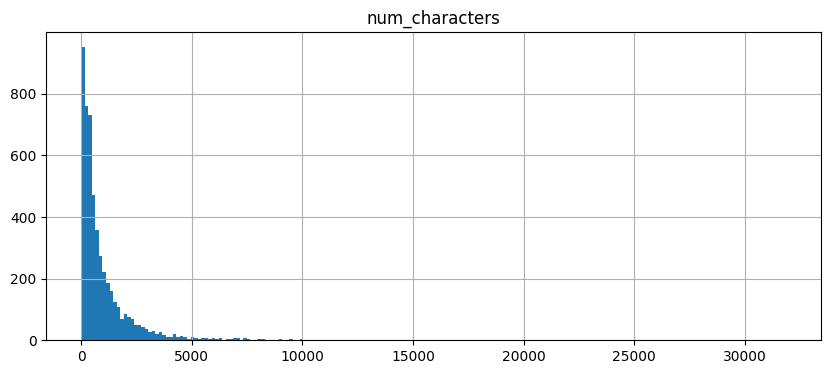

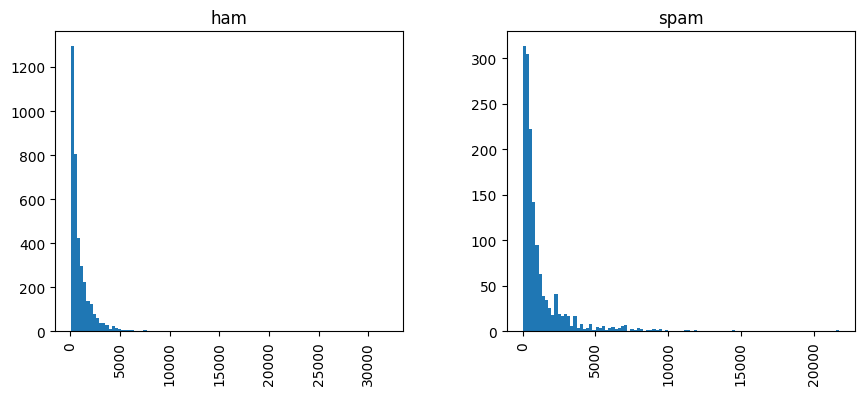

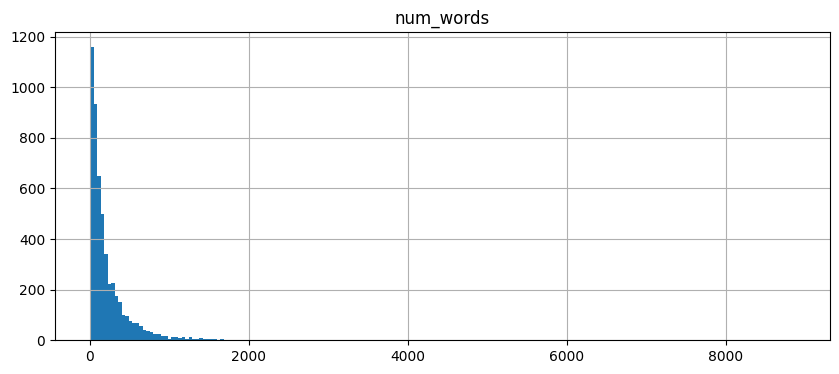

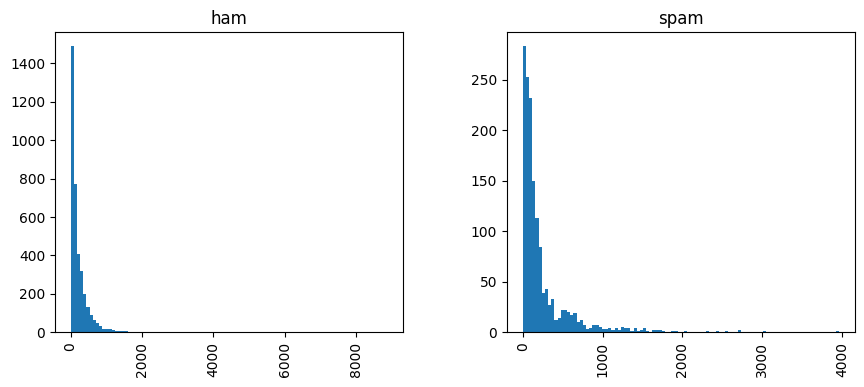

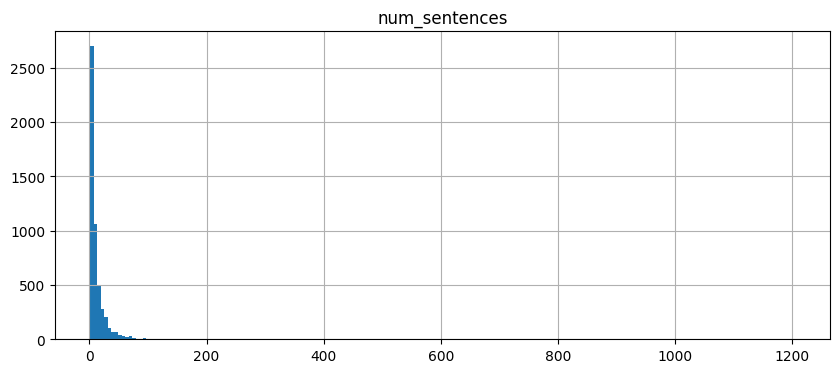

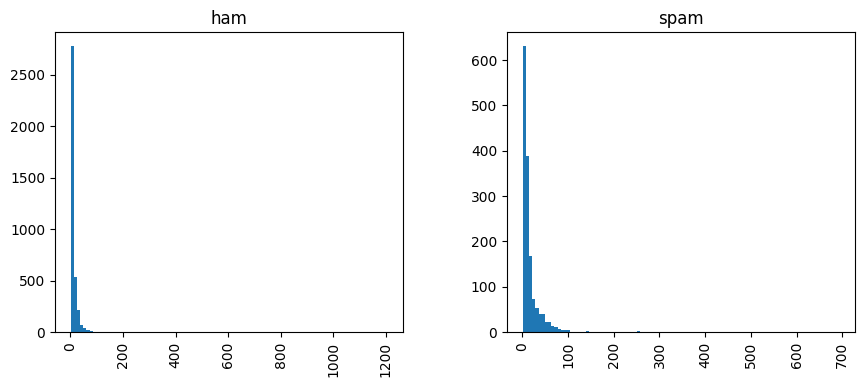

In [6]:
# Show the data informations
print("Ham:")
print(df_dup[df_dup['target'] == 0][['num_characters','num_words','num_sentences']].describe())
print("\nSpam:")
print(df_dup[df_dup['target'] == 1][['num_characters','num_words','num_sentences']].describe())
print("\nBoth:")
print(df_dup[['num_characters','num_words','num_sentences']].describe())

# plot the histogram of lens
df_dup.hist(column='num_characters',bins=200,figsize=(10,4),)
df_dup.hist(column='num_characters',by='label',bins=100,figsize=(10,4))
df_dup.hist(column='num_words',bins=200,figsize=(10,4))
df_dup.hist(column='num_words',by='label',bins=100,figsize=(10,4))
df_dup.hist(column='num_sentences',bins=200,figsize=(10,4))
df_dup.hist(column='num_sentences',by='label',bins=100,figsize=(10,4))

<Axes: xlabel='num_characters', ylabel='Count'>

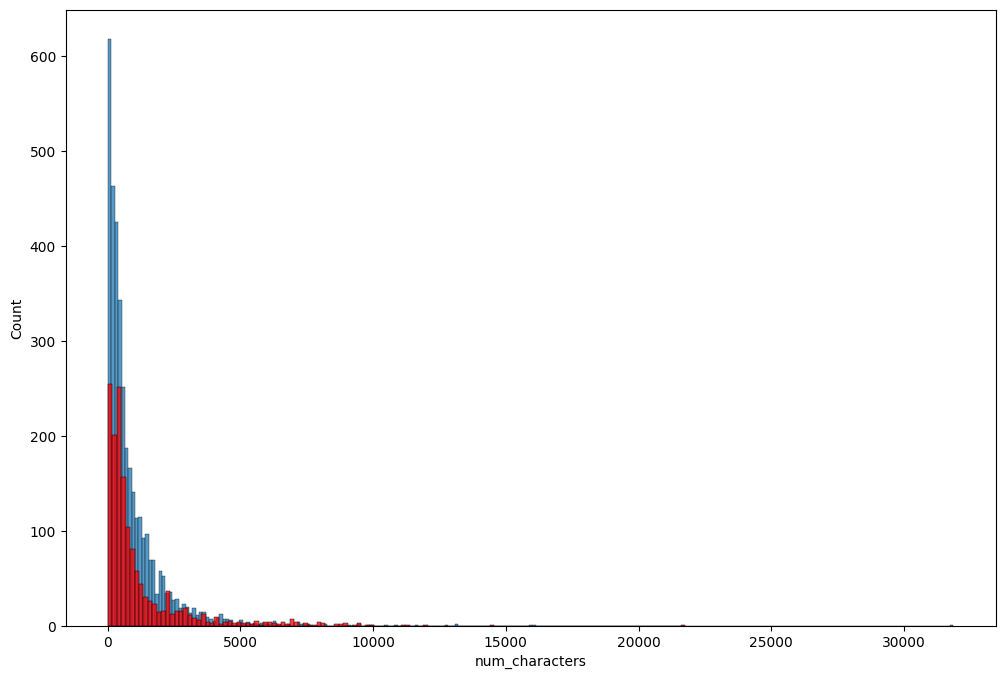

In [7]:
plt.figure(figsize=(12,8))
sns.histplot(df_dup[df_dup['target'] == 0]['num_characters'])
sns.histplot(df_dup[df_dup['target'] == 1]['num_characters'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

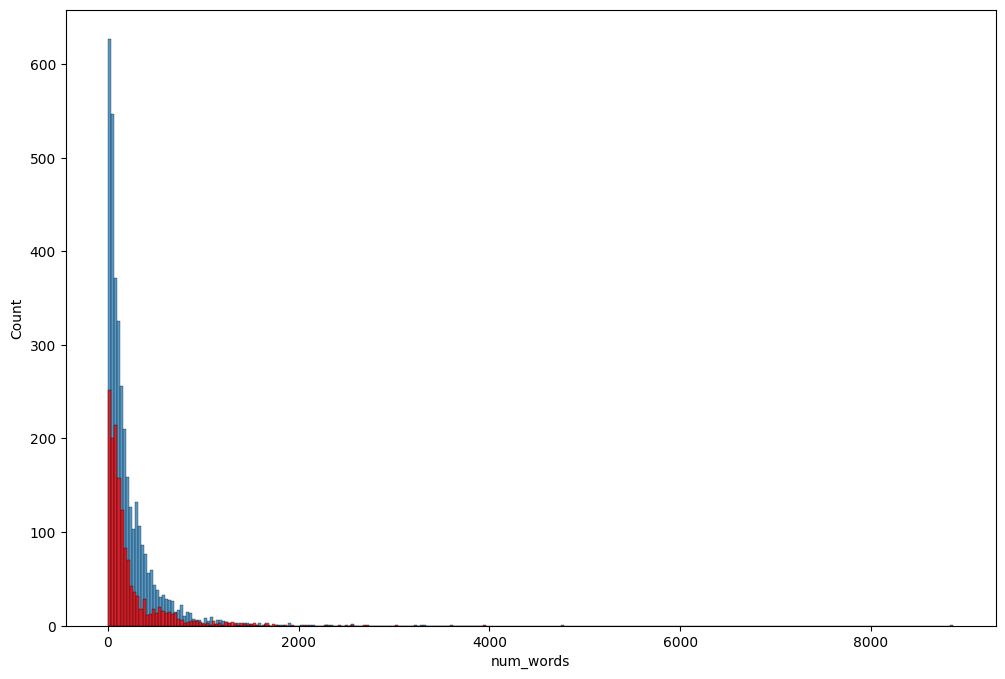

In [8]:
plt.figure(figsize=(12,8))
sns.histplot(df_dup[df_dup['target'] == 0]['num_words'])
sns.histplot(df_dup[df_dup['target'] == 1]['num_words'],color='red')

<Axes: xlabel='num_sentences', ylabel='Count'>

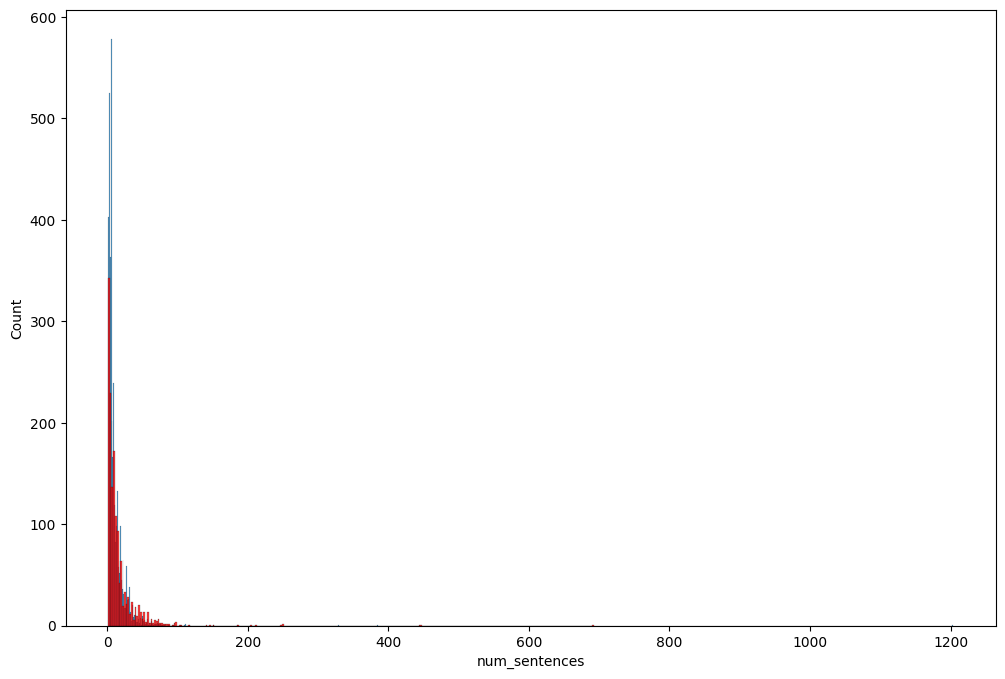

In [9]:
plt.figure(figsize=(12,8))
sns.histplot(df_dup[df_dup['target'] == 0]['num_sentences'])
sns.histplot(df_dup[df_dup['target'] == 1]['num_sentences'],color='red')

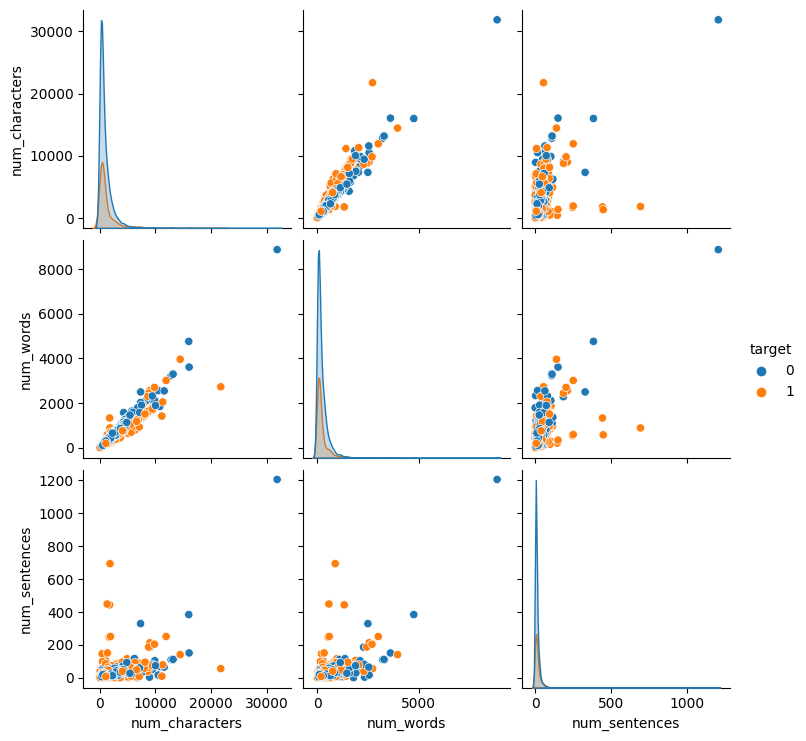

In [10]:
sns.pairplot(df_dup,hue='target')
df_withoutStrings = df_dup.drop(columns=['label','text'],inplace=False)

<Axes: >

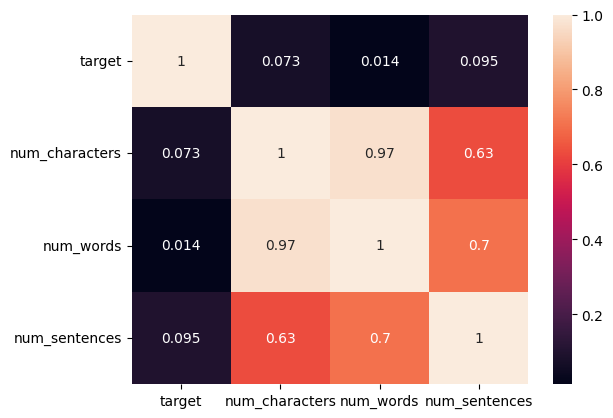

In [11]:
# Show correlation between lens and label
sns.heatmap(df_withoutStrings.corr(),annot=True)

##### Creating bag of words from dataset text

In [12]:
import re
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize) # for print the weight vector
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Tokenization
def tokenize(text):
    # Split text by whitespace and remove punctuation with regex
    tokens = re.findall(r'(?u)\b\w\w+\b', text)
    return tokens

# Vocabulary creation
def create_vocab(corpus):
    # Count occurrence of each word in the entire corpus
    vocab_counts = Counter(word for text in corpus for word in text)
    # Create vocabulary from the words
    vocab = {word: i for i, (word, count) in enumerate(vocab_counts.most_common())}
    return vocab

# Counting word occurrences
def count_words(text, vocab):
    # Count occurrences of words in the text using a vocab
    word_counts = np.zeros(len(vocab), dtype=np.int32)
    for word in text:
        if word in vocab:
            word_counts[vocab[word]] += 1
    return word_counts

# Vectorization
def vectorize(corpus, vocab):
    N, n = len(corpus), len(vocab)
    vectors = np.zeros(shape=(N,n), dtype=np.int32)
    for i, text in enumerate(corpus):
        # Count word occurrences in document using a numpy array
        vector = count_words(text, vocab)
        vectors[i] = vector
    return vectors

# Split the data for train and test
X_train, X_test, y_trn, y_tst = train_test_split(df['text'], df['target'], train_size=0.8)

# Create corpus to train and test
corpus_X_train = [tokenize(text.lower()) for text in X_train] # Tokenize corpus from the text in X_train
corpus_X_test = [tokenize(text.lower()) for text in X_test] # Tokenize corpus from the text in X_test

# Create vocabulary from corpus of only from X_train
vocab = create_vocab(corpus_X_train)

# Vectorize X_train and X_test using vocabulary of X_train
X_trn = vectorize(corpus_X_train, vocab)
X_tst = vectorize(corpus_X_test, vocab)


##### Run the logistic regression model on the dataset and show results

Loss after iteration 0: 0.6931271807599426
Loss after iteration 25: 0.2861684199661522
Loss after iteration 50: 0.23540202478673644
Loss after iteration 75: 0.20635933056261002
Loss after iteration 100: 0.18657278944671424
Loss after iteration 125: 0.17188165329955132
Loss after iteration 150: 0.1603784143759644
Loss after iteration 175: 0.15103459025187013
Loss after iteration 199: 0.14352430925092247
-------------- Scores --------------
Accuracy Score: 0.9758454106280193
F1 Score: {'recall': 0.9519230769230769, 'precision': 0.9674267100977199, 'F1': 0.9596122778675283}
Log Loss: 0.16177747586791155
------------------------------------


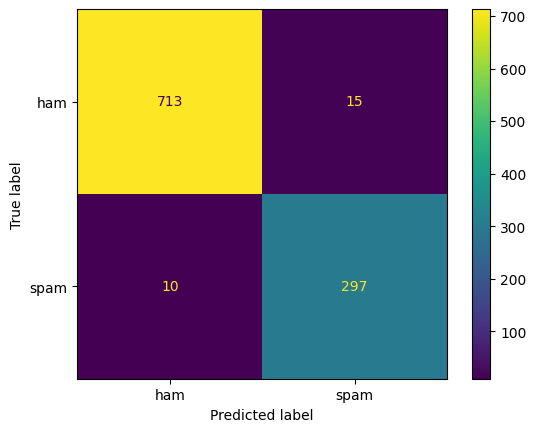

<Figure size 800x600 with 0 Axes>

In [13]:
clf = LogisticReg(learning_rate=0.1,num_iterations=200,verbose=True) # explain below
clf.fit(X_trn,y_trn)
y_tst_pred = clf.predict(X_tst)
# printing Scores for see the results of the model
print('-------------- Scores --------------')
print(f'Accuracy Score: {clf.score(X_tst,y_tst)}')
print(f'F1 Score: {clf.f1_score(y_tst_pred,y_tst)}')
print(f'Log Loss: {clf.log_loss(clf.predict_proba(X_tst),y_tst)}')
print('------------------------------------')
# plot confusion matrix
cm = confusion_matrix(y_tst,y_tst_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['ham','spam'])
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

In [14]:
print(f'The weights vector:\n{clf._weights}')

The weights vector:
[-1.24688495e-01 -1.47118763e-01 -2.04349443e-01  1.07098595e-01
 -1.63551278e-01  2.08379582e-01  8.50230932e-02  1.07608969e-02
  1.57882045e-01 -1.05926309e-01 -1.63724992e-01  4.11254433e-02
  7.21807921e-05 -5.07495148e-01 -5.45719600e-02 -1.01104570e-02
 -3.75634377e-01  5.35923261e-02 -2.60410542e-01 -4.37267727e-02
 -1.26476350e-01  1.33189646e-01 -8.87214374e-02  6.24716232e-02
 -2.32971178e-01  2.91405374e-02  7.67218667e-02 -2.65451370e-01
  4.44271707e-02  1.03746867e-02 -1.71645155e-01 -3.15145213e-01
 -9.89422517e-03  8.36181279e-02 -3.43232311e-01 -3.25357422e-01
 -1.01483560e-01 -1.32000787e-01 -7.94732535e-02 -1.28793313e-01
 -3.90642561e-01 -8.78382413e-02 -9.14537024e-02 -1.83641807e-01
  1.38665852e-01 -2.41061123e-03  1.55768616e-02 -9.15026755e-02
 -2.64089573e-01  1.05709824e-01 -2.85532737e-01 -3.23623148e-01
 -1.39921147e-01 -4.34785344e-02 -1.80116605e-02 -1.38490116e-02
 -2.01330063e-01 -5.57352248e-02  8.97371863e-02  1.07453562e-02
 -1.4

**Motivation to choose parameters**
- I shuffled (re-split and run) few times to see consistency of scores.
-  For decide which predictions are good, i used accuracy score and F1 score with confustion table.
    - I added verbose flag to the model for printing the log loss function of predictions to see the progress of learning.
    - I choosed parameters when i got F1 Score (around 95%+) and that i saw that when i changed paramaters one of scores go up but the second go down, scores didn't rise significantly.
- The learning rate is 0.25 after trying different values and see that lead to good results in most of tests.
-  The num_iterations is 300 because less that 300 usually not enough for reach a good results and more is not increase the score in significant value and some times lead to unbalance score between recall and precision.
- We will prefer maybe the less false positive predictions but it i didn't find one and yet the false positive predictions are relatively low.



#### Task 4 - ROC Cruve on Logistic Regression

The good threshold train: 0.48
The good threshold test: 0.48


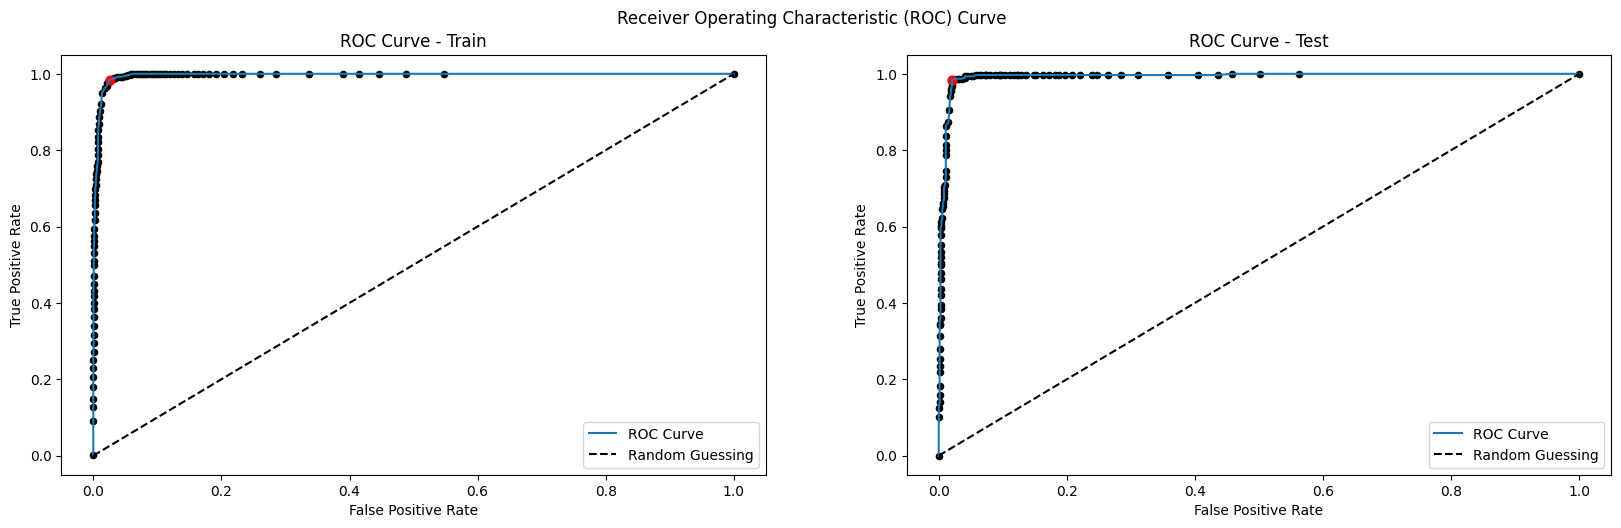

In [55]:
def plot_roc_curve(y_true, y_prob, ax, title):
    # Compute true positive rate (TPR) and false positive rate (FPR) for different thresholds
    thresholds = np.linspace(0, 1, 101)
    tpr_values = []
    fpr_values = []
    num_positive_cases = sum(y_true)
    num_negative_cases = len(y_true) - num_positive_cases
    for threshold in thresholds:
        y_pred = np.where(y_prob < threshold, 0, 1)
        tp = np.sum((y_true == 1) & (y_pred == 1)) # true positive
        fp = np.sum((y_true == 0) & (y_pred == 1)) # false positive
        tpr = tp / num_positive_cases # create tpr score (recall)
        fpr = fp / num_negative_cases # create fpr score (missing rate)
        # record the scores
        tpr_values.append(tpr)
        fpr_values.append(fpr)
    # change the list to np array for aritmetic between arrays
    tpr_values = np.array(tpr_values)
    fpr_values = np.array(fpr_values)
    # pickup the most the most successful theshold
    good_index = np.argmax(tpr_values-fpr_values) # find the most successful theshold index
    good_threshold = thresholds[good_index] # keep the value
    # Plot the ROC curve
    ax.plot(fpr_values, tpr_values, label=f'ROC Curve')
    ax.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    ax.scatter(fpr_values, tpr_values,s=20, color='black')
    ax.scatter(fpr_values[good_index], tpr_values[good_index], marker='o', facecolors='red', edgecolors='red', s=40)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {title}')
    ax.legend(loc='lower right')
    return good_threshold


fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=1, top= 0.95)
fig.suptitle('Receiver Operating Characteristic (ROC) Curve')
ax1 = fig.add_subplot(2,2,1)
good_threshold_train= plot_roc_curve(y_trn,clf.predict_proba(X_trn), ax1, 'Train')
ax2 = fig.add_subplot(2,2,2)
good_threshold_test= plot_roc_curve(y_tst,clf.predict_proba(X_tst), ax2, 'Test')
print(f'The good threshold train: {good_threshold_train:.2f}')
print(f'The good threshold test: {good_threshold_test:.2f}')
plt.show()


**ROC Curve Conclusions**
- In looking on the ROC Curve we can see the the most successful theshold in the interval [0,1] with 101 numbers is usualy around 0.45-0.5 so we should take something in the middle
- The red mark show the place of the threshold on the plot.

#### Task 5 - Linear Programing

In [17]:
# Task 5 - Section 2 - Imports
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

**Task 5 - Linear Programing Data Generator**
###### I left the datasets i created for this task to check my code

In [18]:
# Dataset1 - Linear line with noise

# Define a linear line
a, b = (2, 0)
line = lambda x: a * x + b
# Generate random points close to the line
n_samples, noise_scale = 1000, 10.0
x_1 = np.linspace(-10, 10, n_samples)
x_2 = line(x_1) + np.random.normal(loc=0, scale=noise_scale, size=n_samples)
# Create input features X and labels y
X = np.column_stack((x_1, x_2))  # make X matrix of points
y = np.where(x_2 >= line(x_1), 1, -1)  # change y represent labels

# Flip a random subset of labels to be wrong
num_wrong_labels = y[y==1].shape[0] - 50
y_pos = y == 1
idx = np.random.choice(np.where(y_pos)[0], num_wrong_labels, replace=False)
y[idx] = -1

In [19]:
# Dataset2 Simple Dataset
X = np.array([[1,0],[2,1],[3,-1],[2,4],[1,3],[3,2],[-2,4]])
y = np.array([-1,-1,-1,-1,1,1,1])

In [20]:
# Dataset3 - logic gate dataset

# Define the parameters of the dataset
num_samples, noise_scale = 1000, 10.0
low, high = -10.0, 10.0  # Range of points
# Generate the data
X = np.random.uniform(low=low, high=high, size=(num_samples, 2))
# Add some noise to the labels
y = np.logical_or(X[:, 0] > 0, X[:, 1] > 0).astype(int)
y = np.where(y == 0, -1, y)

**Task 5 - Linear Programing**


In [21]:
N, n= X.shape
# Create A_ub, b_ub, c for LP
obj = np.concatenate([np.zeros(n),np.ones(N)])  # vector c
lhs_ineq = np.concatenate([-y*np.eye(N)@X,-np.eye(N)],axis=1) # matrix A
rhs_ineq = np.array([-1] *N) # vector B
#            bounds for points             bound for support vector
bnd = [(-float("inf"), float("inf"))] *n + [(0, float("inf"))] * N

opt = linprog(c=obj,
            A_ub=lhs_ineq,
            b_ub=rhs_ineq, 
            bounds=bnd,
            method="highs")
print(opt)  # print result of program

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 538.413731609594
              x: [ 1.728e-01  1.848e-01 ...  0.000e+00  2.116e+00]
            nit: 616
          lower:  residual: [       inf        inf ...  0.000e+00
                              2.116e+00]
                 marginals: [ 0.000e+00  0.000e+00 ...  1.000e+00
                              0.000e+00]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 0.000e+00  1.484e+00 ...  1.196e+00
                              0.000e+00]
                 marginals: [-1.000e+00 -0.000e+00 ... -0.000e+00
                             -1.000e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_

**Task 5 - Linear Programing - plot the results** 

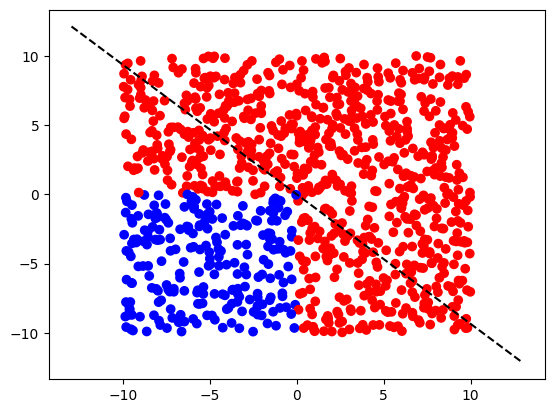

In [22]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(['blue','red']))
x_min, x_max, y_min, y_max = np.amin(X[:, 0]), np.amax(X[:, 0]), np.amin(X[:, 1]), np.amax(X[:, 1])

lx = np.linspace(x_min-3, x_max+3, 100)
w = opt.x
ly = [ -w[0] * p / w[1] for p in lx]

plt.plot(lx, ly,'k--')
plt.show()